### Описание данных  

Файл содержит [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) для некоторого актива. Стакан состоит из ценовых уровней и объема заявок на каждом уровне. Глубина стакана - 5.  

Описание колонок:  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку
midprice - цена актива  
signal - сигнал, полученный от модели, которая оценивает изменение цены 

#### Цена актива
На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = \frac{(askbest(t) + bidbest(t))}{2} $$  

С помощью сигнала от модели определим прогноз цены в будущем:  
$$midprice(t + 1) = midprice(t) + signal(t)$$

### Задачa
Написать свою торговую стратегию, которая будет опираться на сигнал модели для принятия решения.  
#### Ограничения: 
- Максимальная позиция не должна превышать 1
- Нельзя самостоятельно вносить изменения в бэктест
- Стратегия должна содержать текстовое описание  

#### Критерии оценки стратегии:
- Pnl после комиссии 
- Количество сделок > 50

### Считывание данных

In [1]:
# !pip3 install fastparquet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import *

In [3]:
backtest_df = pd.read_parquet('data.parquet')

In [4]:
backtest_df.head(2)

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.32,0.015,-0.004417
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.32,0.015,-0.004417


In [5]:
backtest_df.shape

(7361603, 7)

### Пример стратегии

#### Принцип работы стратегии  
Стратегия - это некоторый набор условий, по которому в каждый момент времени принимается решение, нужно ли сейчас покупать, продавать, либо ничего не делать.  
Результат работы стратегии - необходимый объем сделки (```order_size```). Если значение объема положительное - совершается покупка (buy). Если отрицательное - продажа (sell). Если 0 - ничего не происходит (hold).  

```order_size = 1``` — сделать покупку объемом 1  
```order_size = -1``` — сделать продажу объемом 1  

Совершение сделки на покупку изменяет текущую позицию (```current_position```) в положительную сторону, на продажу - в отрицательную.  
Текущая позиция отражает кумулятивную сумму купленных и проданных объемов.  
Пример изменения текущей позиции:  

```1. order_size = 0 -> current_position = 0```  
```2. order_size = 1 -> current_position = 1  # открытие позиции```  
```3. order_size = -1 -> current_position = 0  # закрытие позиции```  
  
Максимальная позиция (```max_position```) - наибольшее абсолютное значение текущей позиции. Если текущая позиция равна максимальной, нельзя совершать сделки в ту же сторону.  
При ```max_position = 1```:   

```1. order_size = 0 -> current_position = 0```  
```2. order_size = -1 -> current_position = -1```  
```3. order_size = -1 -> current_position = -1  # нельзя превысить max_position```   
```4. order_size = 1 -> current_position = 0```   

In [6]:
def basic_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    '''
    Описание стратегии
    --------------
    Совершает покупку, если сигнал положительный и текущая абсолютная позиция меньше максимальной.
    Совершает продажу, если сигнал отрицательный и текущая абсолютная позиция меньше максимальной.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию)
        и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для сохранения информации с прошлых тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    # prev_signal = storage.get('prev_signal', 0)  # пример использования storage
    if signal > 0:  # покупка
        order_size = min(trade_size, max_position - current_position)  # определение объема сделки
    elif signal < 0:  # продажа
        order_size = -min(trade_size, max_position + current_position)  # определение объема сделки
    else:
        order_size = 0
    # storage['prev_signal'] = signal  # пример использования storage
    
    return order_size

In [7]:
strategy_params = {}
strategy_params['trade_size'] = 1  # максимальное значение = 1
strategy_params['storage'] = {}  

### Бэктест
Для проверки качества стратегии используются исторические данные, на которых с помощью бэктеста симулируется работа стратегии

{'pnl': -7758.215660218272, 'pnl_after_fee': -99987.76854768979, 'actions': 2524253}


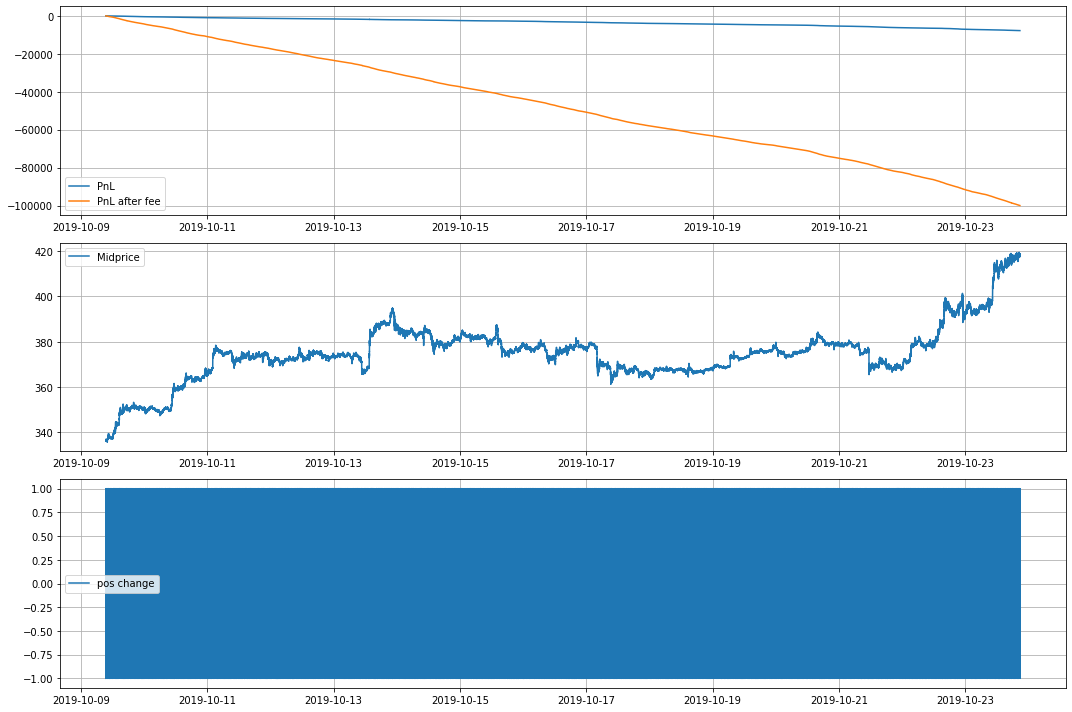

CPU times: user 1min 9s, sys: 2.78 s, total: 1min 12s
Wall time: 1min 14s


<Figure size 432x288 with 0 Axes>

In [8]:
%%time
summary, result = backtest(backtest_df, basic_strategy, strategy_params, viz=True)

Бэктест возвращает результат работы стратегии.  
```summary``` содержит итоговую информацию:
- pnl : Profits and Losses (PnL, P&L) - сумма всех доходов и убытков по закрытым позициям. 
- **pnl_after_fee : Pnl после комиссии. За каждую сделку биржа берёт комиссию. В данном случае она составляет 0.0001 от цены актива в момент совершения сделки. Это ключевой показатель при анализе эффективности стратегии.**  
- actions : Количество сделок, совершенное стратегией  

Выводы по этой стратегии:  
Она слишком чувствительна к сигналу, поэтому совершает большое количество сделок, из которых почти все убыточны. 

```result``` - исходный датафрейм, к которому добавлены данные по стратегии в каждый момент времени. Может использоваться для детального анализа работы стратегии

In [9]:
result

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal,pnl,pnl_after_fee,decisions,pos
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.320,0.015,-0.004417,0.00000,-0.033622,sell,-1.0
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320,0.015,-0.004417,0.00000,-0.033622,hold,-1.0
2019-10-09 09:30:03.565,"[336.42, 336.43, 336.49, 336.51, 336.52]","[3.41067, 27.97455, 8.91917, 5.99121, 13.0]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,0.025,-0.004417,0.00000,-0.033622,hold,-1.0
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,0.030,-0.004417,0.00000,-0.033622,hold,-1.0
2019-10-09 09:30:03.765,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.17]","[8.98892, 8.67933, 9.11755, 125.39419, 27.35777]",336.335,0.020,-0.004417,0.00000,-0.033622,hold,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-23 20:46:47.121,"[417.52, 417.53, 417.54, 417.56, 417.57]","[1.43033, 2.0366, 1.97911, 4.17178, 8.14]","[417.51, 417.48, 417.47, 417.43, 417.42]","[8.22386, 9.416, 72.0, 2.10745, 2.5958]",417.515,-0.005,0.002476,-7758.17566,-99987.603298,buy,1.0
2019-10-23 20:46:47.221,"[417.53, 417.54, 417.56, 417.57, 417.58]","[5.11045, 1.97911, 4.17178, 8.14, 65.51592]","[417.51, 417.47, 417.43, 417.42, 417.41]","[8.22386, 72.0, 2.10745, 2.5958, 0.02522]",417.520,-0.005,-0.003388,-7758.18566,-99987.655049,sell,0.0
2019-10-23 20:46:47.321,"[417.51, 417.52, 417.54, 417.55, 417.56]","[13.88302, 42.45231, 1.97911, 2.65357, 4.07006]","[417.43, 417.42, 417.41, 417.4, 417.39]","[2.10745, 2.5958, 0.02522, 0.2144, 0.07536]",417.470,0.040,0.007493,-7758.18566,-99987.696800,buy,1.0
2019-10-23 20:46:47.421,"[417.49, 417.51, 417.52, 417.54, 417.55]","[0.12961, 13.88302, 40.41571, 1.97911, 2.53593]","[417.43, 417.42, 417.41, 417.4, 417.39]","[2.10745, 2.5958, 0.02522, 0.2144, 0.07536]",417.460,0.055,0.011664,-7758.18566,-99987.696800,hold,1.0
